In [1]:
#set up a Gillespie model 
#We need to fix a model
#recover known parameter values via gradient descent
#It should be easy to set up the experiment

In [16]:
import jax
import jax.numpy as jnp
from jax import grad, random
from jax import lax
import unittest
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import optax
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.integrate import solve_ivp
import torch
import torch.optim as optim
import os

In [18]:
#example from Storm's paper with:
# Reactions:
# R1: A + A -> C      (k1)
# R2: A + B -> D      (k2)
# R3: ∅    -> A       (k3)
# R4: ∅    -> B       (k4)

# Stoichiometry: rows = reactions, cols = species [A, B]
S = jnp.array([
    [-2,  0],  # R1: A + A -> C
    [-1, -1],  # R2: A + B -> D
    [ 1,  0],  # R3: ∅ -> A
    [ 0,  1],  # R4: ∅ -> B
])

def propensities(k1, k2, k3, k4, x):
    A, B = x
    #a1 = k1 * A * (A - 1) / 2.0 # A + A -> C (divided by 2 to avoid overcounting)
    a1 = k1 * A * (A - 1) 
    a2 = k2 * A * B              # A + B -> D
    a3 = k3                      # ∅ -> A
    a4 = k4                      # ∅ -> B
    return jnp.array([a1, a2, a3, a4])

def gillespie_step(key, x, S, k1, k2, k3, k4):
    a = propensities(k1, k2, k3, k4, x)
    a0 = jnp.sum(a)
    key, subkey1, subkey2 = jax.random.split(key, 3)

    r1 = jax.random.uniform(subkey1)
    tau = (1/a0)*jnp.log(1/r1)
    probs = a / a0
    cumulative = jnp.cumsum(probs)
    r2 = jax.random.uniform(subkey2)
    i = jnp.searchsorted(cumulative, r2)

    x_new = x + S[i]
    return key, x_new, tau

def gillespie_step2(key, x, k1, k2, k3, k4):
    """
    Should work like gillespie_step but is the more direct way of writing it.
    """
    A, B = x
    a = propensities(k1, k2, k3, k4, x)
    a1, a2, a3, a4 =  a[0], a[1], a[2], a[3]
    a0 = jnp.sum(a)
    key, subkey1, subkey2 = jax.random.split(key, 3)
    
    r1 = jax.random.uniform(subkey1)
    tau = (1/a0)*jnp.log(1/r1)
    r2 = jax.random.uniform(subkey2)
    

    if r2 >= 0 and a1/a0 > r2:
        A -= 2
        B = B
    elif r2 >= a1/a0 and r2 < (a1+a2)/a0:
        A -= 1
        B -= 1
    elif r2 >= (a1+a2)/a0 and (a1+a2+a3)/a0 > r2:
        A += 1
        B = B
    elif (a1+a2 + a3)/a0 <= r2 and r2 < 1:
        A = A
        B+=1

    x_new = [A, B]
    return key, x_new, tau


def gillespie_simulation(tmax, x0, S, k1, k2, k3, k4, key):
#def gillespie_simulation(tmax, x0, k1, k2, k3, k4, key):
    t = 0
    x = x0
    trajectory = [(t, x)]

    while t < tmax:
        #key, x, tau = gillespie_step2(key, x, k1, k2, k3, k4)
        key, x, tau = gillespie_step(key, x, S, k1, k2, k3, k4)
        t += tau
        trajectory.append((t, x))

    return trajectory

# Initial conditions
A0 = 0
B0 = 0
x0 = jnp.array([A0, B0])  # [A, B]
key = jax.random.PRNGKey(42)
#tmax = 1000.0
tmax = 100

# Rate constants
k1 = 0.001
k2 = 0.01
k3 = 1.2
k4 = 1.0

# Run simulation
trajectory = gillespie_simulation(tmax, x0, S, k1, k2, k3, k4, key)
#trajectory = gillespie_simulation(tmax, x0, k1, k2, k3, k4, key)



# Solve ODEs

In [21]:
#must define combined ODES:
def odes(t, y):
    A, B = y
    dA_dt =  -2*k1*(A**2) - k2*A*B + k3
    dB_dt = -k2*A*B + k4
    return [dA_dt, dB_dt]

A0 = 0
B0 = 0
y0 = [A0, B0]

tspan = (0,100)
t_eval = np.linspace(*tspan, 300)

sol = solve_ivp(odes, tspan, y0, t_eval = t_eval)

# Graph simulations and solved ODE

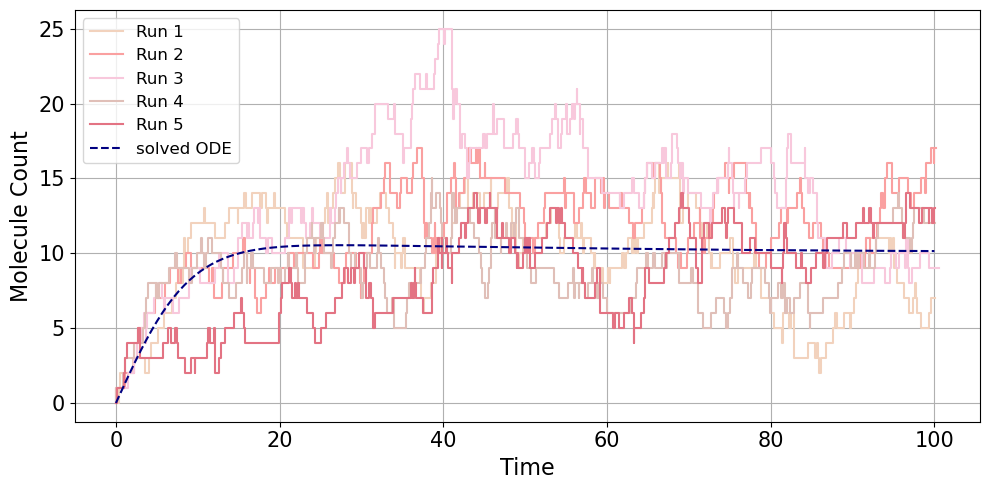

In [24]:
#plotting the above for many keys: 
trajectories = []
keys = [1, 2, 10, 55, 42]
for i in keys:
    key = jax.random.PRNGKey(i)
    trajectory = gillespie_simulation(tmax, x0, S, k1, k2, k3, k4, key)
    #trajectory = gillespie_simulation(tmax, x0, k1, k2, k3, k4, key)
    trajectories.append(trajectory)

blues = ["navy", "#0F52BA", "#87CEEB",  "#4682B4", "#A7C7E7"]
reds = ["#D2042D", "#811331", "#E30B5C", "#FF0000", "#FAA0A0"]
pinks = [ "#F2D2BD", "#FAA0A0", "#F8C8DC", "#E0BFB8", "#E37383"]

plt.figure(figsize=(10, 5))
# Unpack the trajectory: list of (t, x)
for ind, i in enumerate(trajectories, start = 1):
    times, states = zip(*i)

    # Convert times and states to JAX arrays
    times = jnp.array(times)
    states = jnp.stack([jnp.array(s) for s in states])  # ensure all are jnp.array

    # Convert to NumPy arrays for plotting
    times = jnp.array(times)
    states = jnp.stack(states)  # shape (num_steps, 2)
    A_vals = states[:, 0]

    plt.step(times, A_vals, label = f"Run {ind}", color = pinks[ind-1])

plt.plot(sol.t, sol.y[0], label = "solved ODE", color = "navy", linestyle = "--")

plt.xlabel('Time', fontsize = 16)
plt.ylabel('Molecule Count', fontsize = 16)
#plt.title('Stochastic Simulation of Molecule A over Time')
plt.legend(fontsize = 12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig("reactant_A.png", dpi=150)
plt.show()



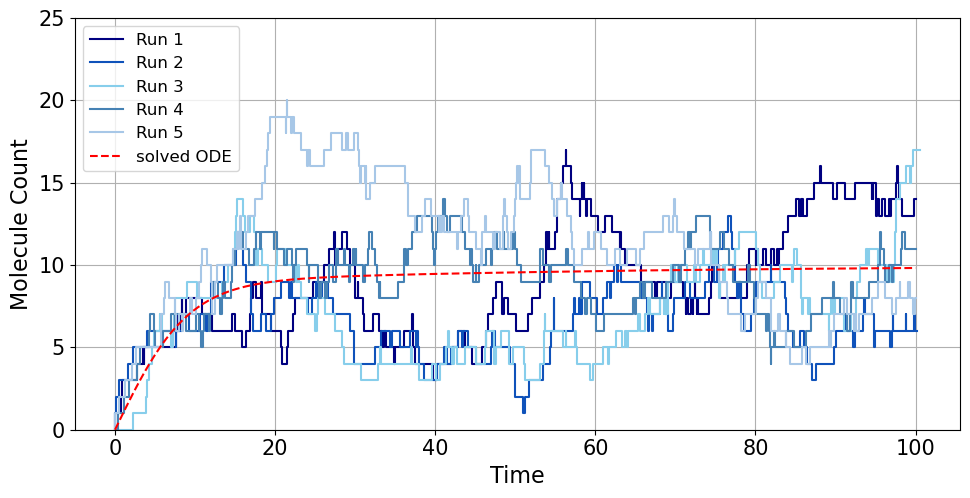

In [25]:
plt.figure(figsize=(10, 5))
# Unpack the trajectory: list of (t, x)
for ind,i in enumerate(trajectories, start = 1):
    times, states = zip(*i)

    # Convert times and states to JAX arrays
    times = jnp.array(times)
    states = jnp.stack([jnp.array(s) for s in states])  # ensure all are jnp.array

    # Convert to NumPy arrays for plotting
    times = jnp.array(times)
    states = jnp.stack(states)  # shape (num_steps, 2)
    B_vals = states[:, 1]

    plt.step(times, B_vals, label = f"Run {ind}", color = blues[ind-1])

plt.plot(sol.t, sol.y[1], color = "red", label = "solved ODE", linestyle = "--")
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Molecule Count', fontsize = 16)
#plt.title('Stochastic Simulation of Molecule B over Time')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 12)
plt.grid(True)
plt.tight_layout()
plt.ylim(0,25)
plt.savefig("reactant_B.png", dpi=150)
plt.show()



In [28]:
tmax = 10000
trajectories = []
keys = [1, 2, 10, 55, 100]
for i in keys:
    key = jax.random.PRNGKey(i)
    trajectory = gillespie_simulation(tmax, x0, S, k1, k2, k3, k4, key)
    #trajectory = gillespie_simulation(tmax, x0, k1, k2, k3, k4, key)
    trajectories.append(trajectory)

mean_A = []
mean_B = []
for i in trajectories:
    times, states = zip(*i)

    # Convert times and states to JAX arrays
    times = jnp.array(times)
    states = jnp.stack([jnp.array(s) for s in states])  # ensure all are jnp.array

    # Convert to NumPy arrays for plotting
    times = jnp.array(times)
    states = jnp.stack(states)  # shape (num_steps, 2)
    A_vals = states[:, 0]
    B_vals = states[:, 1]
    mean_A.append(np.mean(A_vals[100:]))
    mean_B.append(np.mean(B_vals[100:]))

In [29]:
np.mean(mean_A)

10.202045

In [30]:
np.mean(mean_B)

11.769333

In [266]:
k1_opt

Array(80.63263, dtype=float32)